In [2]:
# Read in goal_shot_rows.csv

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import seaborn as sns
import matplotlib.pyplot as plt

# So Version 0.2 eh?

The goal for this model is to work on the xC, yC columns to standardize them from 0-100 (instead of -100 to 100), the tricky bit here will be also adjusting the previous events co-ordinates to make sure I don't actually break anything. 


Some observations as I go here:

1. The previous event type was generally meant to be "hey was the previous shot a wrister or a slapshot", but is also picking up types of penalties that lead to a penalty shot. I'm wondering if I should include penalty shots in here at all, but will admit it's kinda interesting to see if it has an effect or not. (Really, I should find a way to mux it into a "is penalty shot" variable, but that's probably down the road a bit).
2. Looking at the data a little more closely, I can see I was accidentally including shootouts. Can probably get around this by excluding "Period 5" from the data.
3. Oy vey. I really messed up with the line `input_data2 = input_data2.applymap(lambda x: 1 if x == True else 0)` applying to EVERYTHING, not just the binary values. Time to fix that!
4. Digging more into code, for the 2022 season, only ~85% of recorded shots actually have x/y coordinates. That seems shockingly low!
5. Another 2.9% of shots just have 0,0 as the coordinates! I've read complaints, but truly had no idea it was this bad!
6. Another 13.8% of shots just happen to be at the faceoff dots! The good news is that the ratio of goals to shots is pretty unaltered by this, so we're not going to accidentally train the model to favor one over the other.

7. In total: Only ~70% of goals/shots have actual useful location data


With all this in mind, I don't want to lose another -ton- of data due to previous events not having x/y co-ordinates. So I'll just keep them as NaN (boo). I'll also need to scrub and remove the "this event definitely happened at the faceoff circle" data and convert that to NaN as well. This will hopefully preserve the validity of the "change in angle" info I'm hoping the model will pick up on.

In [130]:
# Read in goal_shot_rows.csv
goal_shot_rows = pd.read_csv('goal_shot_rows.csv')

# remove all instances where Period is 5 or 0
goal_shot_rows = goal_shot_rows[goal_shot_rows['Period'] != 0]
goal_shot_rows = goal_shot_rows[goal_shot_rows['Period'] != 5]

# create a subset of the dataframe, with only the 'Period', 'Seconds_Elapsed', 'Strength', 'Type', 'xC', 'yC'
# 'prev_Event', 'prev_Period', 'prev_Seconds_Elapsed', 'prev_Strength', 'prev_Type', 'prev_xC', 'prev_yC'

input_data = goal_shot_rows[['Event', 'Period', 'Seconds_Elapsed', 'Strength', 'Type', 'xC', 'yC', 'prev_Event', 'prev_Period', 'prev_Seconds_Elapsed', 'prev_Strength', 'prev_Type', 'prev_xC', 'prev_yC']]

result_data = goal_shot_rows['Event']




# Remove all rows of input_data where xC or Yc is NaN
print(len(input_data))
print(input_data['Event'].value_counts())
input_data = input_data.dropna(subset=['xC', 'yC'])
print(len(input_data))
# remove all rows where xC = 0 and yC = 0


input_data = input_data[(input_data['xC'] != 0) | (input_data['yC'] != 0)]


print(len(input_data))
# remove all rows where xC = 69 or -69 and yC is 22 or -22
input_data = input_data[(input_data['xC'] != 69) & (input_data['xC'] != -69) | (input_data['yC'] != 22) & (input_data['yC'] != -22)]
print(len(input_data))
input_data = input_data[(input_data['xC'] != 20) & (input_data['xC'] != -20) | (input_data['yC'] != 22) & (input_data['yC'] != -22)]
print(len(input_data))
print(input_data['Event'].value_counts())

result_data = input_data['Event']
# change result_data to be 1 if it's "GOAL", 0 otherwise
result_data = result_data.apply(lambda x: 1 if x == "GOAL" else 0)

input_data = input_data.drop(columns=['Event'])


87487
Event
SHOT    78688
GOAL     8799
Name: count, dtype: int64
74578
72019
62482
61049
Event
SHOT    54915
GOAL     6134
Name: count, dtype: int64


In [131]:
# Split out the data between numeric values (can carry forward) and categorical values (need to be turned into binary columns)
input_data_numeric = input_data[['Period', 'Seconds_Elapsed', 'xC', 'yC', 'prev_Seconds_Elapsed', 'prev_xC', 'prev_yC']]
input_data_categorical = pd.DataFrame()


# change result_data to be 1 if it's "GOAL", 0 otherwise
result_data = result_data.apply(lambda x: 1 if x == "GOAL" else 0)

for column in ['Strength', 'Type', 'prev_Event']:
    dummy_columns = pd.get_dummies(input_data[column])
    input_data_categorical = pd.concat([dummy_columns, input_data_categorical], axis=1)

for column in ['prev_Event', 'prev_Strength', 'prev_Type']:
    dummy_columns = pd.get_dummies(input_data[column])
    
    # rename all columns with a prefix of "prev_"
    dummy_columns.columns = ['prev_' + str(col) for col in dummy_columns.columns]

    input_data_categorical = pd.concat([input_data_categorical, dummy_columns], axis=1)


# change all True/False to 1/0
input_data_categorical = input_data_categorical.applymap(lambda x: 1 if x == True else 0)

# combine the two dataframes
input_data_combined = pd.concat([input_data_numeric, input_data_categorical], axis=1)

#set input_data2 to be all floats
input_data_combined = input_data_combined.astype(float)

C:\Users\JoshG\AppData\Local\Temp\ipykernel_3436\2304407857.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  input_data_categorical = input_data_categorical.applymap(lambda x: 1 if x == True else 0)


xC
-81.0    800
-80.0    766
 81.0    746
-82.0    722
 80.0    714
        ... 
-26.0     48
 24.0     47
 25.0     47
-25.0     45
-24.0     35
Name: count, Length: 199, dtype: int64
yC
 0.0     1817
 1.0     1751
-1.0     1450
 2.0     1319
 3.0     1252
         ... 
 32.0     434
 26.0     423
-41.0     292
 42.0     188
-42.0      68
Name: count, Length: 85, dtype: int64


c:\Users\JoshG\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\JoshG\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


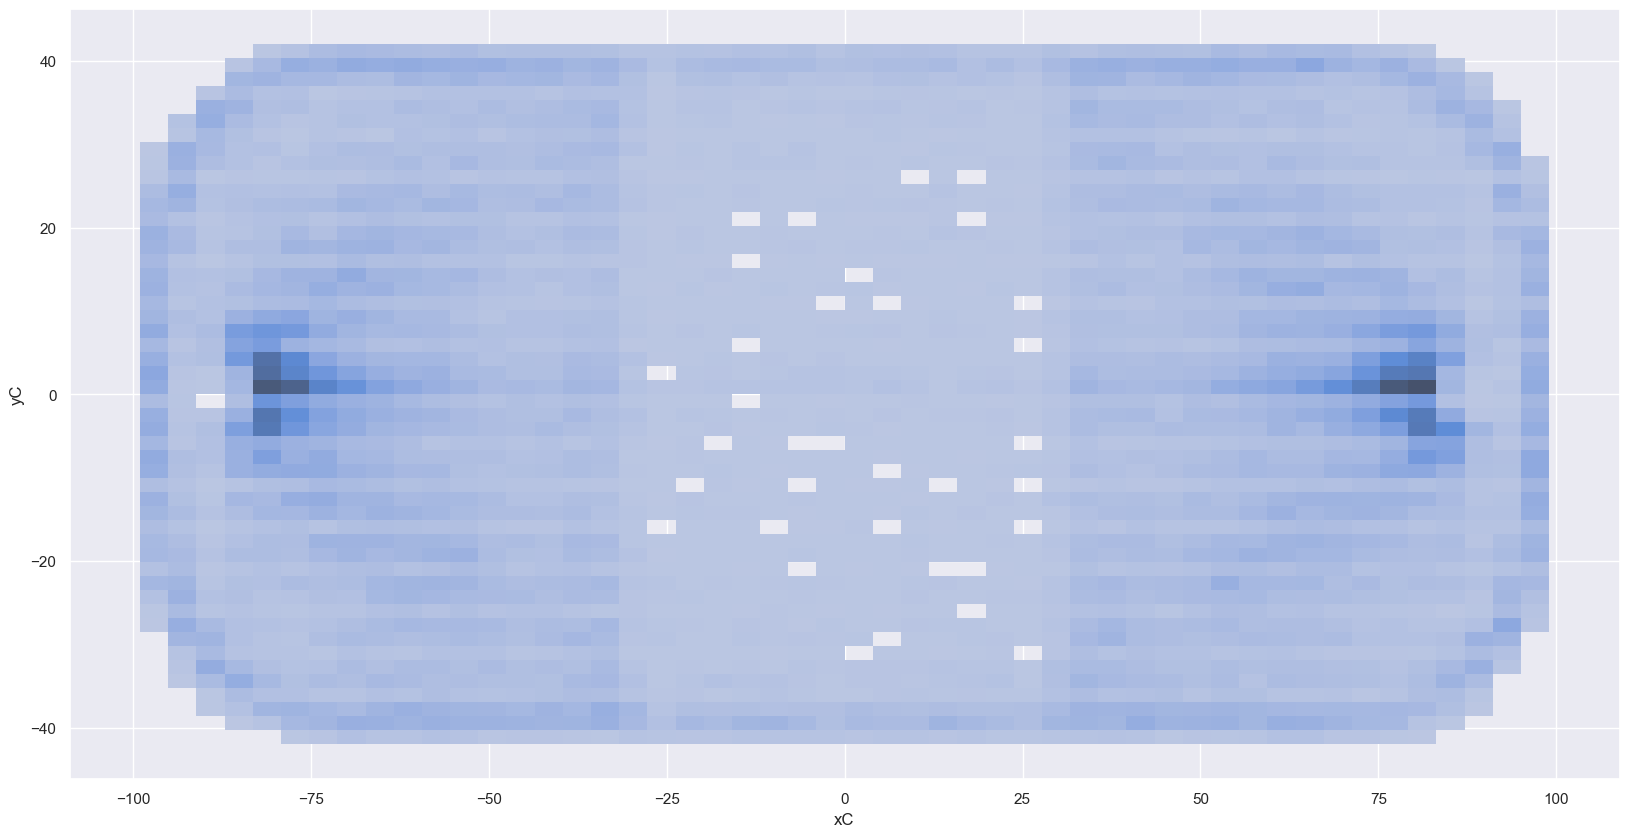

In [132]:
# let's do some data validation, and get the list of columns:

# get the list of columns in input_data2
# print(input_data_combined.columns)


coord_df = pd.concat([input_data_combined['xC'], input_data_combined['yC']], axis=1)
sns.histplot(coord_df, x="xC", y="yC", bins=50)
sns.set_theme(rc={'figure.figsize':(20,10)})


# Get the most common combinations of xC and yC
print(input_data_combined['xC'].value_counts())
print(input_data_combined['yC'].value_counts())





In [136]:
# change all NaN numbers to 0
input_data_combined = input_data_combined.fillna(0)

In [137]:
x = torch.tensor(input_data_combined.values, dtype=torch.float32)
y = torch.tensor(result_data.values, dtype=torch.float32)

In [141]:
model = nn.Sequential(
    nn.Linear(71, 120),
    nn.ReLU(),
    nn.Linear(120, 60),
    nn.ReLU(),
    nn.Linear(60, 1),
    nn.Sigmoid()
)

print(model)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Sequential(
  (0): Linear(in_features=71, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=25, bias=True)
  (3): ReLU()
  (4): Linear(in_features=25, out_features=1, bias=True)
  (5): Sigmoid()
)


In [142]:
n_epochs = 1000
batch_size = 3000
 
for epoch in range(n_epochs):
    for i in range(0, len(x), batch_size):
        Xbatch = x[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y[i:i+batch_size]
        #loss = loss_fn(y_pred, ybatch)
        loss = loss_fn(y_pred.squeeze(), ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'{epoch}, {loss}')


# compute accuracy (no_grad is optional)
with torch.no_grad():
    y_pred = model(x)
 
accuracy = (y_pred.round() == y).float().mean()
print(f"Accuracy {accuracy}")

0, 0.00031139611382968724
1, 8.942138811107725e-05
2, 5.487344242283143e-05
3, 3.968664168496616e-05
4, 2.9969405659358017e-05
5, 2.3171562133939005e-05
6, 1.8255937902722508e-05
7, 1.4614748579333536e-05
8, 1.1870029993588105e-05
9, 9.7636902864906e-06
10, 8.119102858472615e-06
11, 6.814561857027002e-06
12, 5.7704642131284345e-06
13, 4.924543645756785e-06
14, 4.233326762914658e-06
15, 3.6646770240622573e-06
16, 3.192793656126014e-06
17, 2.7978342131973477e-06
18, 2.458666358506889e-06
19, 2.1692412701668218e-06
20, 1.922703404488857e-06
21, 1.7101377807193785e-06
22, 1.526993173683877e-06
23, 1.3682879398402292e-06
24, 1.2304755045988713e-06
25, 1.1102782764282892e-06
26, 1.0050208629763802e-06
27, 9.124827897721843e-07
28, 8.30835631404625e-07
29, 7.585302341794886e-07
30, 6.942858021830034e-07
31, 6.369036782416515e-07
32, 5.855198992321675e-07
33, 5.39469795057812e-07
34, 4.980761900696962e-07
35, 4.607717301041703e-07
36, 4.27077310405366e-07
37, 3.9656177364122414e-07
38, 3.68862

(0.265, 0.28)

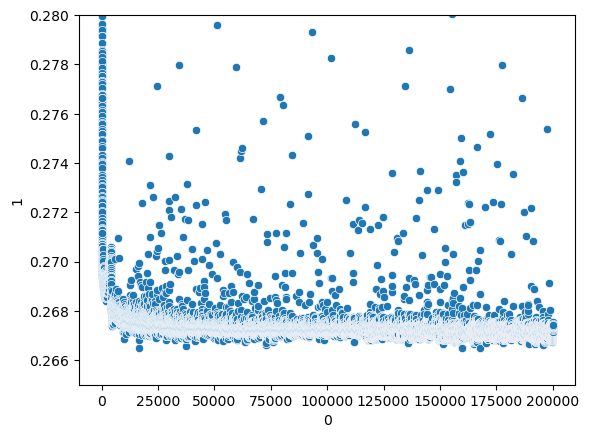

In [10]:
# open 0419Model.csv as a text file, and remove all non-numeric characters
data = ""
with open('0419Model.csv', 'r') as file:
    data = file.read()
    data = data.replace('Finished epoch ', '')
    # write it back to another file
with open('0419Model.csv', 'w') as file:
    file.write(data)


# read in the file as a dataframe
model_data = pd.read_csv('0419Model.csv', header=None)

# create a scatterplot of mode_data
sns.scatterplot(x=model_data[0], y=model_data[1])

# limit the scatterplot y axis to 0.25 to 0.3
plt.ylim(0.265, 0.28)